In [1]:
# Import:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from toolbox.experiment import Experiment
from toolbox.SINDy import SINDy
from toolbox.symbolic_SINDy import symbolic_SINDy
from toolbox.cusum import CUSUM
from toolbox.auxiliary_functions import set_param_freq
from data import SINDy_data, equations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [7]:
# Select ODE:
ode_name = 'TVVdpODE2'
ode_param = "5.0,0.5,3.14"
freq = 20
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)

# Parameters:
freq_SR = 20
n_sample = 50 
noise_ratio = 0.01
seed = 100 
n_seed = 1 
dt = 1 / freq
dim_x = 3
dim_k = 0
SW_length = 15 # SINDy sliding window length
SW_length_SR = 10 # SR sliding window length
H = 70 # length of the experiment
lazy = False # if True, we do not recompute the building blocks with SR
symbolic = True # if True, SR call is allowed, otw. simple SINDy is used throughout the whole experiment

# CUSUM parameters:
N = 8
eps = 0.1
threshold = 1.

In [3]:
# # Generate data: (16min 46.8sec)
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, 0, H)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/TVVdpODE2_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

In [3]:
# Load data:
file_path = 'saved/data/TVVdpODE2_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [4]:
# Initialize experiment and model discovery methods:
exp = Experiment(ode, ode_param, freq_SR, n_sample, noise_ratio, seed, n_seed, dt, dim_x, dim_k, SW_length, SW_length_SR, H, lazy, symbolic)

cusum = CUSUM(N, eps, threshold)

SINDy_method = SINDy(degree=3, include_bias=True, threshold=0.4)

SR_method = 'SR-T' # symbolic regression method chosen 
x_id = 0  # equation to be identified by SR 
symbolic_SINDy_method = symbolic_SINDy(SR_method, x_id=0, degree=3, product=True, threshold=0.3, penalty=14.6, max_patience=10)

In [ ]:
# Run the experiment:

while exp.T <= exp.H:

    print(f't: {exp.T}')
    # update time-window:
    X_list_t = [x[(exp.T0*freq):(exp.T*freq)] for x in X_list]
    dX_list_t = [dx[(exp.T0*freq):(exp.T*freq)] for dx in dX_list]  

    exp.step_forward(SINDy_method, symbolic_SINDy_method, cusum, X_list_t, dX_list_t, param_list, feature_names, CP_threshold=1.36)
    
    # building block search time: 4m 43.8s
    # best symbolic sindy model:
    # T=30 1m 14.8s
    # T=33 46.0s
    # total time: 47m 52.8s

    # Other time search: 31, 32, 48

t: 15


SINDy model:
(X0)' = 4.725 X0 + -1.223 X1 + -4.695 X0 X1^2
(X1)' = 1.006 X0
(X2)' = 1.004 1
Model complexity:  5
Lasso penalty:  12.652139841368596
RMSE:  0.7002838188082567

t: 16
Time:  16
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.8123406335344248

t: 17
Time:  17
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.8729831008245842

t: 18
Time:  18
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.6081486383371331

t: 19
Time:  19
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.9561811528808322

t: 20
Time:  20
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.5857402198424799

t: 21
Time:  21
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.4009069002811927

t: 22
Time:  22
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  1.0092705727647449

t: 23
Time:  23
CUSUM quantity:  0.17081069986675532
CUSUM quantity:  0
Change point: False
RMSE:  1.1109564570497523


- T=30 1m 14.8s
- T=33 46.0s

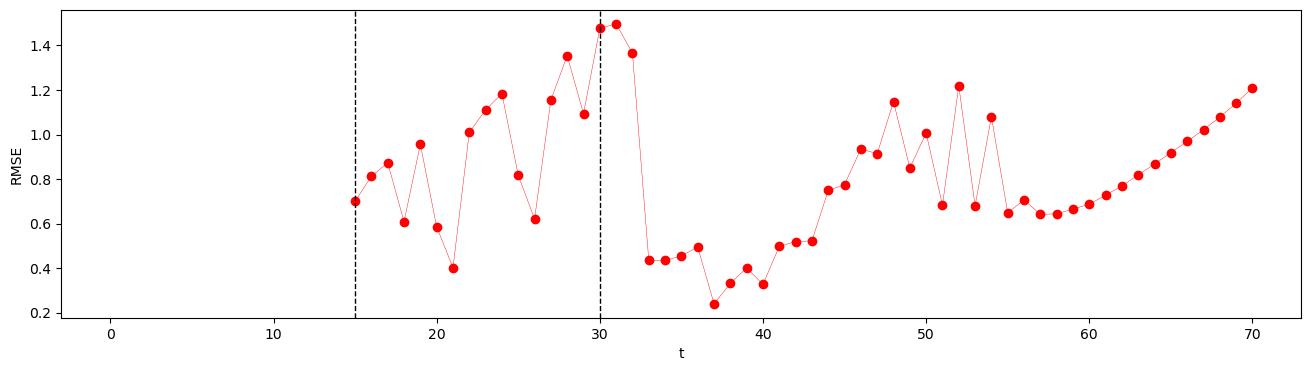

In [7]:
exp.plot_RMSE() 

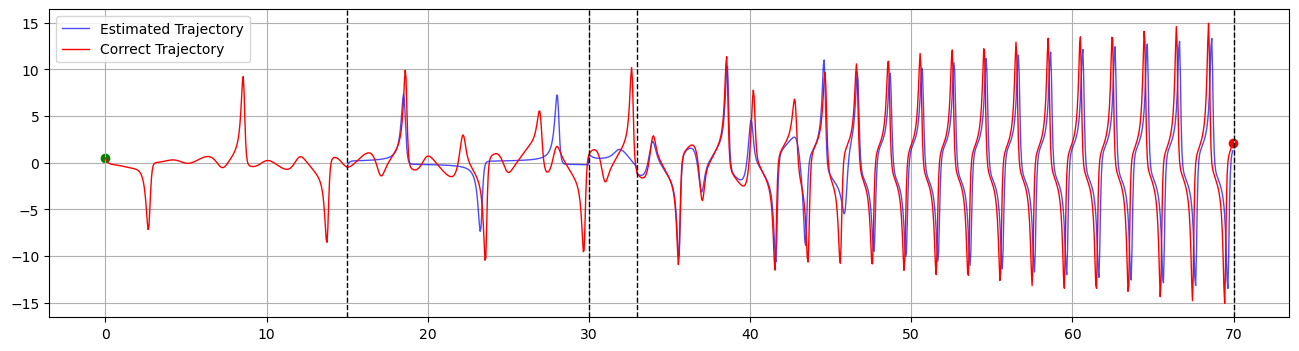

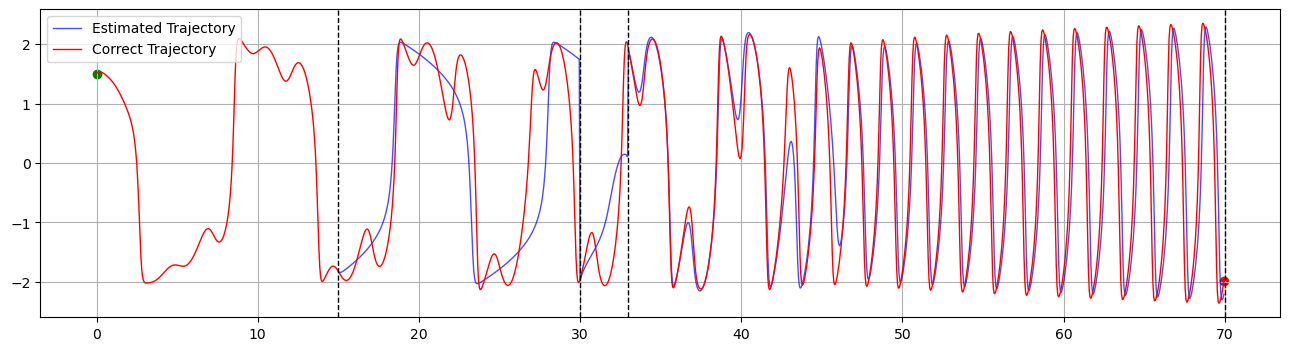

In [8]:
from data.SINDy_data import evaluate_RMSE_d, evaluate_traj_d_1D
start = [0.5, 1.5, 0.]

x_id = 0

plot_times_1 = exp.turning_points.copy() 
plot_models_1 = exp.model_history.copy()
plot_times_1.append(exp.H)
plot_models_1.insert(0, plot_models_1[0])

xt_true1 = []
pred_list1 = []
time_vector_1 = np.arange(0, plot_times_1[-1], exp.dt)
time_vector_2 = np.arange(plot_times_1[1], plot_times_1[-1], exp.dt)
for i in range(len(plot_models_1)):
    xt_true_i, pred_i = evaluate_traj_d_1D(plot_models_1[i], exp.ode, 20, 1, start, start, plot_times_1[i], plot_times_1[i+1], x_id, exp.dim_x, exp.dim_k, plot=False)
    if i == 0:
        xt_true1 = np.concatenate((xt_true1, xt_true_i), axis = 0)
    else: 
        xt_true1 = np.concatenate((xt_true1, xt_true_i), axis = 0)
        pred_list1 = np.concatenate((pred_list1, pred_i), axis = 0)


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(time_vector_2, pred_list1, color='blue', linewidth=1.0, alpha=0.7, label='Estimated Trajectory')
ax.plot(time_vector_1, xt_true1, color='red', linewidth=1.0, label='Correct Trajectory')
ax.scatter(time_vector_1[-1], xt_true1[-1], color='red')
ax.scatter(time_vector_1[0], xt_true1[0], color='green')
ax.legend()
ax.grid()
for x in [plot_times_1[1], plot_times_1[2], plot_times_1[3], plot_times_1[4]]: 
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.0, label='Vertical Line' if x == 1 else "")



x_id = 1

plot_times_1 = exp.turning_points.copy() 
plot_models_1 = exp.model_history.copy()
plot_times_1.append(exp.H)
plot_models_1.insert(0, plot_models_1[0])

xt_true2 = []
pred_list2 = []
time_vector_1 = np.arange(0, plot_times_1[-1], exp.dt)
time_vector_2 = np.arange(plot_times_1[1], plot_times_1[-1], exp.dt)
for i in range(len(plot_models_1)):
    xt_true_i, pred_i = evaluate_traj_d_1D(plot_models_1[i], exp.ode, 20, 1, start, start, plot_times_1[i], plot_times_1[i+1], x_id, exp.dim_x, exp.dim_k, plot=False)
    if i == 0:
        xt_true2 = np.concatenate((xt_true2, xt_true_i), axis = 0)
    else: 
        xt_true2 = np.concatenate((xt_true2, xt_true_i), axis = 0)
        pred_list2 = np.concatenate((pred_list2, pred_i), axis = 0)


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(time_vector_2, pred_list2, color='blue', linewidth=1.0, alpha=0.7, label='Estimated Trajectory')
ax.plot(time_vector_1, xt_true2, color='red', linewidth=1.0, label='Correct Trajectory')
ax.scatter(time_vector_1[-1], xt_true2[-1], color='red')
ax.scatter(time_vector_1[0], xt_true2[0], color='green')
ax.legend()
ax.grid()
for x in [plot_times_1[1], plot_times_1[2], plot_times_1[3], plot_times_1[4]]:  
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.0, label='Vertical Line' if x == 1 else "")

## Plot report 

- Plot della ground truth trajectory con le stelline in prossimità dei change point reali (rosso)
- Plot con tutto insieme
- Plot RMSE

In [10]:
# Real trajectory noise free
xt_true = np.stack((xt_true1, xt_true2), axis = 0) # shape (2, 1600)
# Real trajectory with noise
xt_true_noise = np.array(X_list)[0, :1600, :2].transpose() # shape (2, 1600)
# Both associated with 
t1 = time_vector_1

# On-the-fly model prediction
xt_pred = np.stack((pred_list1, pred_list2), axis = 0)
# Associated with
t2 = time_vector_2

# Model and change point detected
models = plot_models_1.copy()
change_model = plot_times_1.copy()
change_real = []

# RMSE
rmse_vec = exp.rmse_history

In [11]:
# Save experiment:
file_path = 'saved/experiment/TVVdpODE2_exp.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((xt_true, xt_true_noise, t1, xt_pred, t2, models, change_model, change_real, rmse_vec), f)

In [2]:
# Load data:
file_path = 'saved/experiment/TVVdpODE2_exp.pkl'
with open(file_path, 'rb') as f:
    xt_true, xt_true_noise, t1, xt_pred, t2, models, change_model, change_real, rmse_vec = dill.load(f)

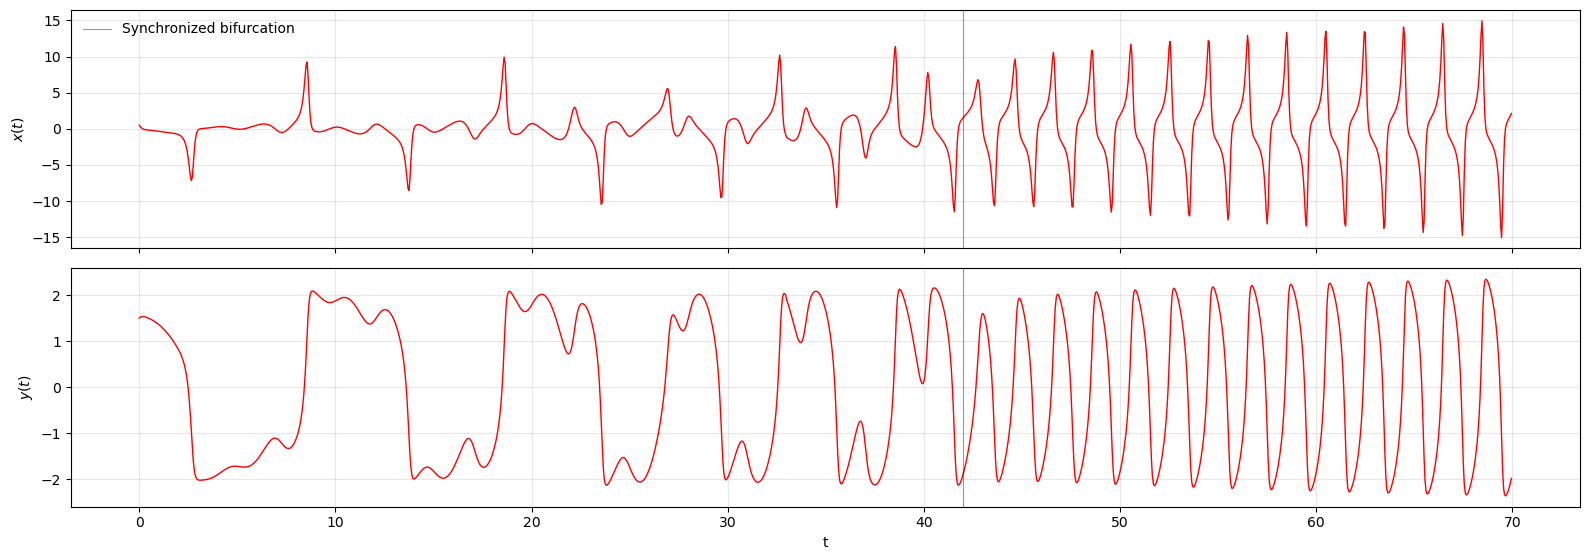

In [3]:
import numpy as np
import matplotlib.pyplot as plt
change_real = [42]

# Ripristina impostazioni standard di Matplotlib
plt.rcdefaults()

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

# Primo stato
axes[0].plot(t1, xt_true[0, :], lw=1, color='red')
axes[0].set_ylabel("$x(t)$")
axes[0].grid(True, alpha=0.3)

# Secondo stato
axes[1].plot(t1, xt_true[1, :], lw=1, color='red')
axes[1].set_xlabel("t")
axes[1].set_ylabel("$y(t)$")
axes[1].grid(True, alpha=0.3)

# Change points
# Change points
for ax in axes:
    ax.axvline(change_real[0], lw=0.8, color='k', alpha=0.4)

# Handle fittizio per la legenda
from matplotlib.lines import Line2D
change_handle = Line2D(
    [], [], color='k', lw=0.8, alpha=0.4, label='Synchronized bifurcation'
)

axes[0].legend(handles=[change_handle], loc='upper left', frameon=False)

# fig.suptitle("Noise-free trajectory in time")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


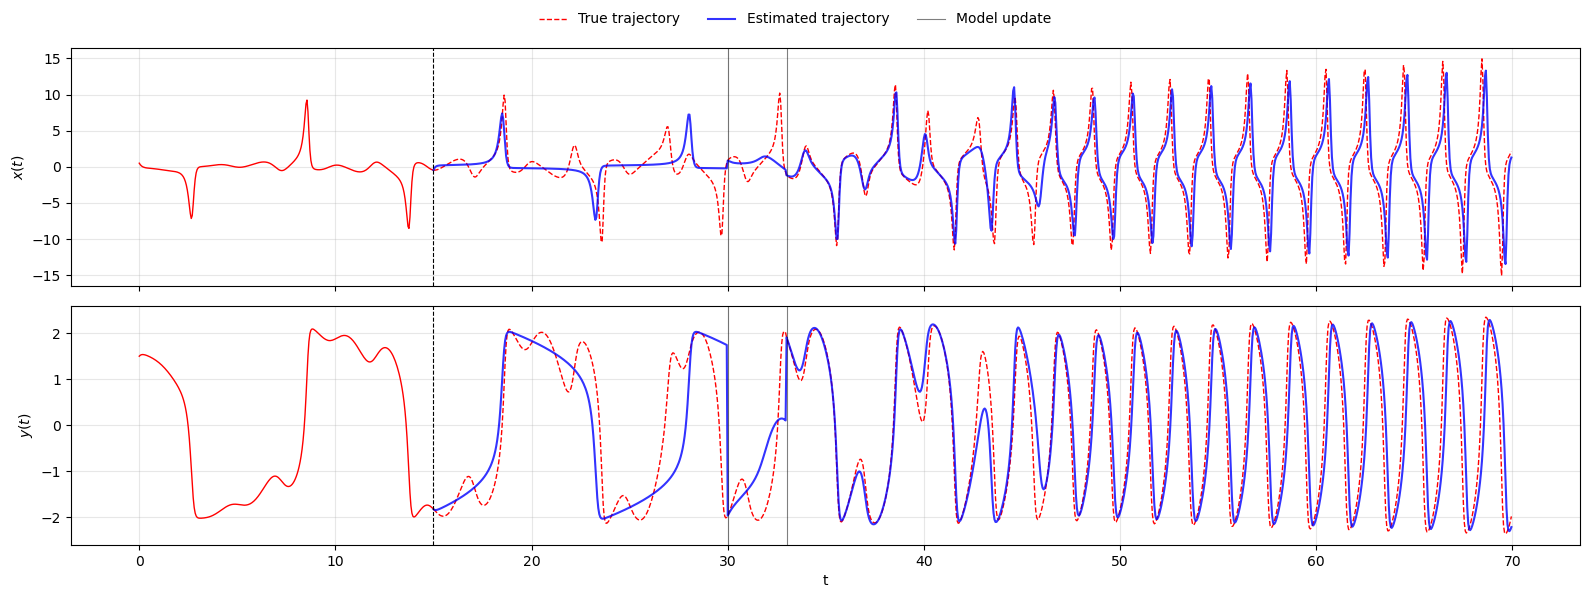

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Ripristina impostazioni standard di Matplotlib
plt.rcdefaults()

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

# Primo stato
axes[0].plot(t1[300:], xt_true[0, 300:], lw=1, color='red', label="True trajectory", linestyle='--')
axes[0].set_ylabel("$x(t)$")
axes[0].grid(True, alpha=0.3)
# Primo stato
axes[0].plot(t1[0:300], xt_true[0, 0:300], lw=1, color='red')
axes[0].plot(t2, xt_pred[0, :], lw=1.5, color='blue', label="Estimated trajectory", alpha = 0.8)

# Secondo stato
axes[1].plot(t1[300:], xt_true[1, 300:], lw=1, color='red', label="True trajectory", linestyle='--')
axes[1].set_xlabel("t")
axes[1].set_ylabel("$y(t)$")
axes[1].grid(True, alpha=0.3)
# Secondo stato
axes[1].plot(t1[0:300], xt_true[1, 0:300], lw=1, color='red')
axes[1].plot(t2, xt_pred[1, :], lw=1.5, color='blue', label="Estimated trajectory", alpha = 0.8)

# Model update
for ax in axes:
    ax.axvline(15, lw=0.8, color='black', alpha=1, linestyle='--') # End control
    ax.axvline(33, lw=0.8, color='k', alpha=0.5) # Model update
    ax.axvline(30, lw=0.8, color='k', alpha=0.5) # Model update



# Recupera handle e label dal primo asse
handles, labels = axes[0].get_legend_handles_labels()

# Handle fittizio per il model update
model_update_handle = Line2D(
    [0], [0],
    color='k',
    lw=0.8,
    linestyle='-',
    alpha=0.5,
    label="Model update"
)

handles.append(model_update_handle)
labels.append("Model update")

fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,          # <-- tutte su una riga
    frameon=False
)


# fig.suptitle("Noise-free trajectory in time")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


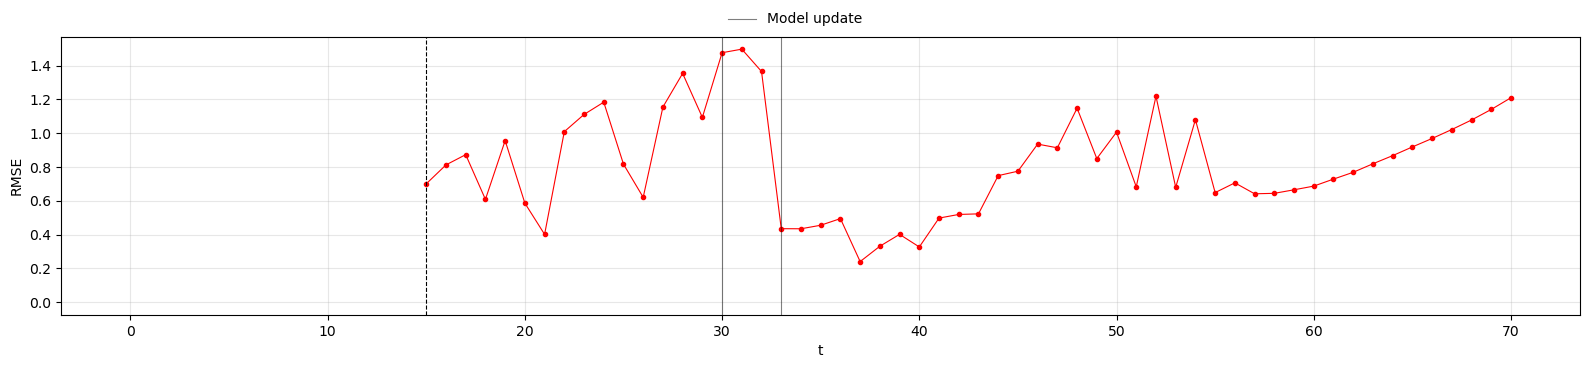

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

time_vector = np.arange(15, H + 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 3.7))

# RMSE
ax.plot(time_vector, rmse_vec, 'r-', lw=0.8)
ax.plot(time_vector, rmse_vec, 'ro', ms=3)

# Plot fittizio per forzare il dominio temporale (come t1)
ax.plot(t1, np.zeros_like(t1), alpha=0)

# Labels
ax.set_xlabel("t")
ax.set_ylabel("RMSE")

# Grid minimale
ax.grid(True, alpha=0.3)

# Eventi temporali
ax.axvline(15, lw=0.8, color='black', alpha=1, linestyle='--')  # End control (NO legenda)
ax.axvline(30, lw=0.8, color='k', alpha=0.5)                    # Model update
ax.axvline(33, lw=0.8, color='k', alpha=0.5)                    # Model update

# Handle fittizio SOLO per Model update
model_update_handle = Line2D(
    [0], [0],
    color='k',
    lw=0.8,
    alpha=0.5,
    label="Model update"
)

# Legenda: STESSE impostazioni del plot sopra
fig.legend(
    handles=[model_update_handle],
    loc="upper center",
    ncol=1,
    frameon=False
)

# Layout IDENTICO
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Plot dei quattro coefficienti nel tempo (?)